In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [187]:
initial_df = pd.read_csv("../data/processed_data/sales_2019.csv",
                         parse_dates=["OrderDate"])

In [13]:
initial_df.head(2)

,OrderID,Product,QuantityOrdered,PriceEach,OrderDate,PurchaseAddress,Sales,Hour,Month,Day,DayName,Year,StreetAddress,CityName,ZipAddress,StreetName,StreetNumber,ZipCode,StateCode
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,8,4,19,Friday,2019,917 1st St,Dallas,TX 75001,1st St,917,75001,TX
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,22,4,7,Sunday,2019,682 Chestnut St,Boston,MA 02215,Chestnut St,682,2215,MA


In [188]:
df = initial_df.set_index(keys=["OrderDate"])

In [50]:
from sktime.split import temporal_train_test_split
X_train, X_test = temporal_train_test_split(y=df["Sales"].resample("D").sum(), test_size=0.2)

In [51]:
X_val, X_test = temporal_train_test_split(y=X_test, test_size=0.5)

In [65]:
X_test = X_test.drop(index="2020-01-01")

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(-50.0, 0, ''),
  Text(0.0, 0, '2019-01-01 00:00:00'),
  Text(50.0, 0, '2019-02-20 00:00:00'),
  Text(100.0, 0, '2019-04-11 00:00:00'),
  Text(150.0, 0, '2019-05-31 00:00:00'),
  Text(200.0, 0, '2019-07-20 00:00:00'),
  Text(250.0, 0, '2019-09-08 00:00:00'),
  Text(300.0, 0, '2019-10-28 00:00:00'),
  Text(350.0, 0, '2019-12-17 00:00:00'),
  Text(400.0, 0, '')])

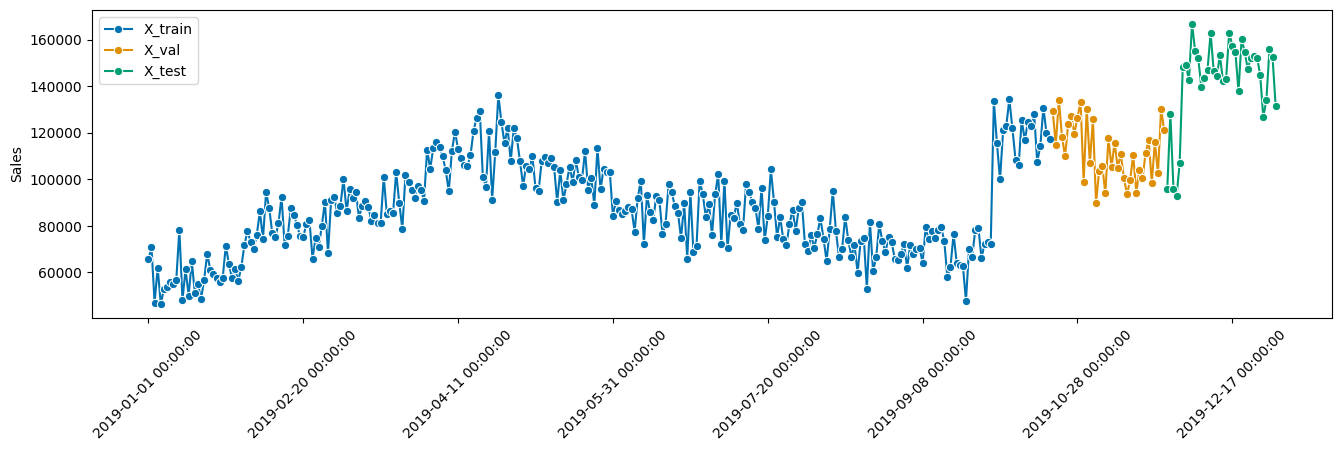

In [66]:
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
plot_series(X_train,X_val, X_test, labels=["X_train","X_val", "X_test"])
plt.xticks(rotation=45)

## Seasonality & Trend

(array([17897., 17928., 17956., 17987., 18017., 18048., 18078., 18109.,
        18140., 18170.]),
 [Text(17897.0, 0, '2019-01'),
  Text(17928.0, 0, '2019-02'),
  Text(17956.0, 0, '2019-03'),
  Text(17987.0, 0, '2019-04'),
  Text(18017.0, 0, '2019-05'),
  Text(18048.0, 0, '2019-06'),
  Text(18078.0, 0, '2019-07'),
  Text(18109.0, 0, '2019-08'),
  Text(18140.0, 0, '2019-09'),
  Text(18170.0, 0, '2019-10')])

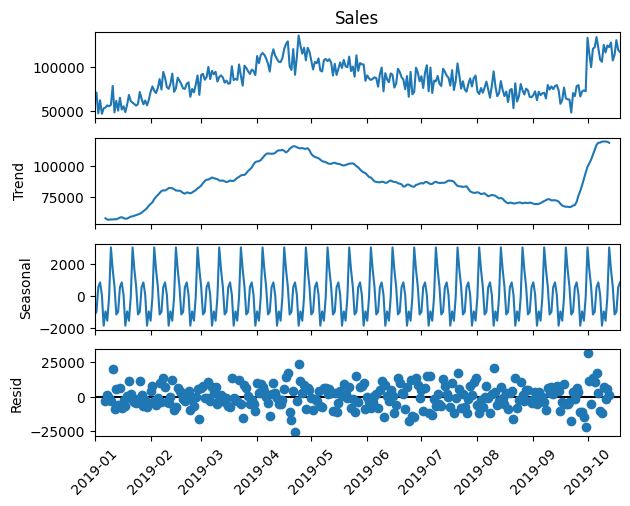

In [199]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(X_train, model='additive', period=12)
result.plot()
plt.xticks(rotation=45)

<Axes: >

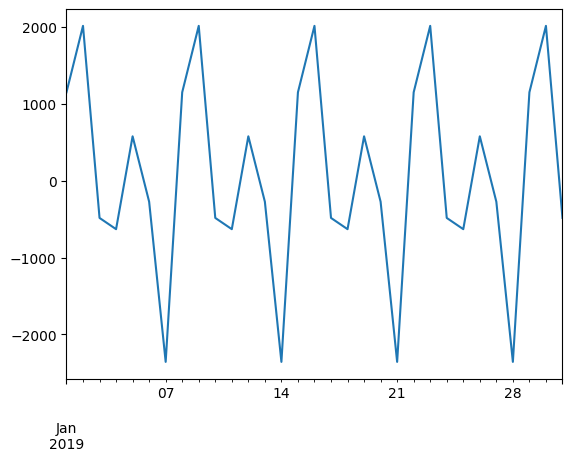

In [160]:
result.seasonal.loc["2019-01-01":"2019-01-31"].plot()

- We have a seasonal pattern that is not linear.
- With a period of 7.

In [4]:
# initial_df = initial_df.sort_values(by=["OrderDate"], ascending=True)

In [169]:
# initial_df["Product"].value_counts()

In [170]:
# initial_df["CityName"].value_counts().plot(kind="bar")

In [171]:
# initial_df["StateCode"].value_counts().plot(kind="bar")

In [172]:
# initial_df["ZipCode"].value_counts().plot(kind="bar")

## Autocorrelation

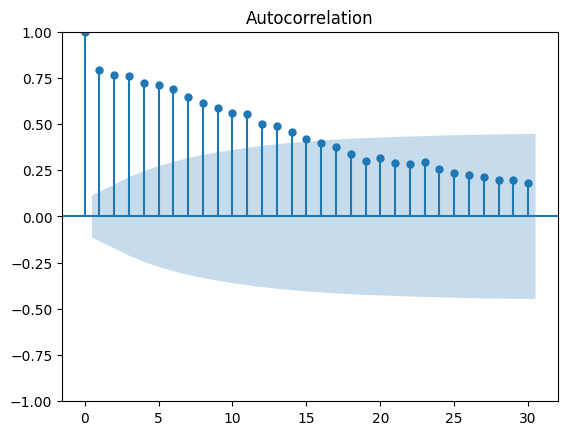

In [201]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(X_train, lags=30, alpha=0.05)
plt.show()

- ACF can be used to find the order of the order of the MA(q) model
- It shows that the sales are highly correlated with the past sales.

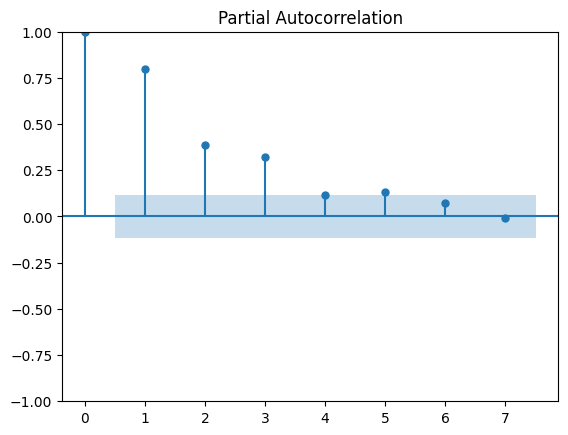

In [174]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(X_train, lags=7,
          alpha=0.05,
          method='ols'
          )
plt.show()

- PACF can be used to find the order of the order of the *AR(p)* model
- A It shows that the sales at one day are highly correlated with the sales at the 3 previous day.

## To Sum Up
- The sales are highly correlated with the past sales.
- The sales at one day are highly correlated with the sales at the 3 previous day.
- Autoregressive model may be a good choice to predict the sales.


In [199]:
# fig, ax = plt.subplots(figsize=(10, 6))
# df_by_day.boxplot(by="Hour", column="Sales", ax=ax)
# df_by_day.groupby('Hour')['Sales'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Sales')
# ax.set_title('Sales distribution by day')
# fig.suptitle('')
# plt.show();

In [200]:
# fig, ax = plt.subplots(figsize=(10, 6))
# df_by_day.boxplot(by="Month", column="Sales", ax=ax)
# df_by_day.groupby('Month')['Sales'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Sales')
# ax.set_title('Sales distribution by day')
# fig.suptitle('')
# plt.show();

In [175]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

In [202]:
# step 1: data specification

# step 2: specifying forecasting horizon
fh = ForecastingHorizon(X_val.index, is_relative=False)

# step 3: specifying the forecasting algorithm
# With the seasonal parameter set to 7
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(X_train)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

In [177]:
from sktime.forecasting.base import BaseForecaster
class SalesForecaster:
    def __init__(self, forecaster: BaseForecaster):
        """
        A class of forecaster to predict sales

        Args:
            forecaster (BaseForecaster): The forecaster to predict sales
        """
        self.forecaster = forecaster
    def fit(self, data):
        self.forecaster.fit(data)
    def predict(self, fh: ForecastingHorizon):
        return self.forecaster.predict(fh)

(array([-40.,   0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360.]),
 [Text(-40.0, 0, ''),
  Text(0.0, 0, '2019-01-01 00:00:00'),
  Text(40.0, 0, '2019-02-10 00:00:00'),
  Text(80.0, 0, '2019-03-22 00:00:00'),
  Text(120.0, 0, '2019-05-01 00:00:00'),
  Text(160.0, 0, '2019-06-10 00:00:00'),
  Text(200.0, 0, '2019-07-20 00:00:00'),
  Text(240.0, 0, '2019-08-29 00:00:00'),
  Text(280.0, 0, '2019-10-08 00:00:00'),
  Text(320.0, 0, '2019-11-17 00:00:00'),
  Text(360.0, 0, '')])

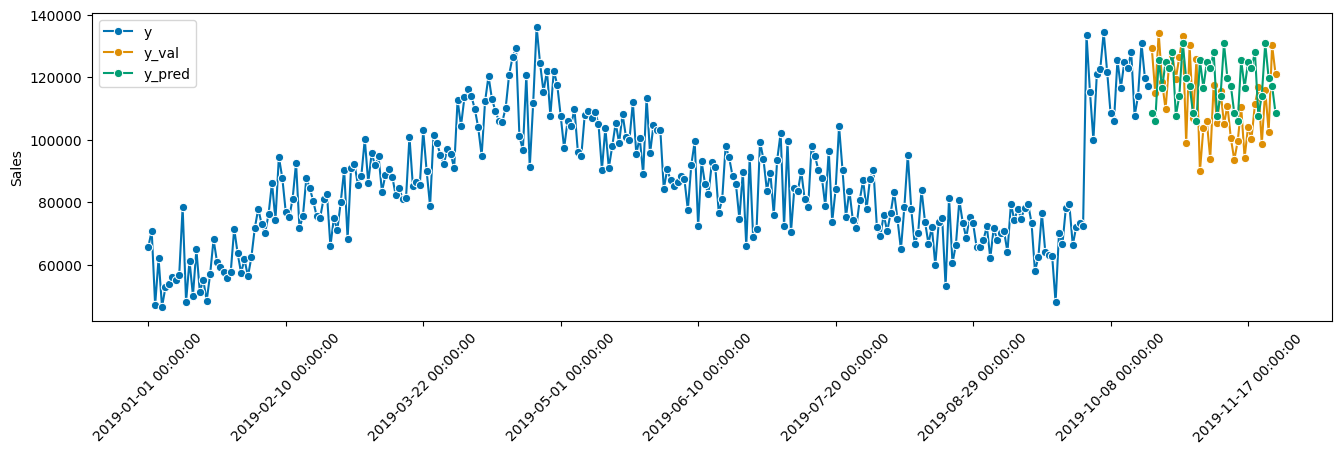

In [203]:
# optional: plotting predictions and past data
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
plot_series(X_train,X_val, y_pred, labels=["y","y_val", "y_pred"])
plt.xticks(rotation=45)

In [206]:
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import BaggingForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.ets import AutoETS
forecaster = BaggingForecaster(
    STLBootstrapTransformer(sp=12),
    NaiveForecaster(sp=7, strategy="last"),
    PolynomialTrendForecaster(degree=2),
    # AutoETS(sp=12),
)

In [207]:
forecaster.fit(y=X_train, fh=fh)

BaggingForecaster(bootstrap_transformer=STLBootstrapTransformer(),
                  forecaster=NaiveForecaster(sp=7),
                  sp=PolynomialTrendForecaster(degree=2))

In [181]:
y_pred = forecaster.predict(fh=fh) 

(array([-40.,   0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360.]),
 [Text(-40.0, 0, ''),
  Text(0.0, 0, '2019-01-01 00:00:00'),
  Text(40.0, 0, '2019-02-10 00:00:00'),
  Text(80.0, 0, '2019-03-22 00:00:00'),
  Text(120.0, 0, '2019-05-01 00:00:00'),
  Text(160.0, 0, '2019-06-10 00:00:00'),
  Text(200.0, 0, '2019-07-20 00:00:00'),
  Text(240.0, 0, '2019-08-29 00:00:00'),
  Text(280.0, 0, '2019-10-08 00:00:00'),
  Text(320.0, 0, '2019-11-17 00:00:00'),
  Text(360.0, 0, '')])

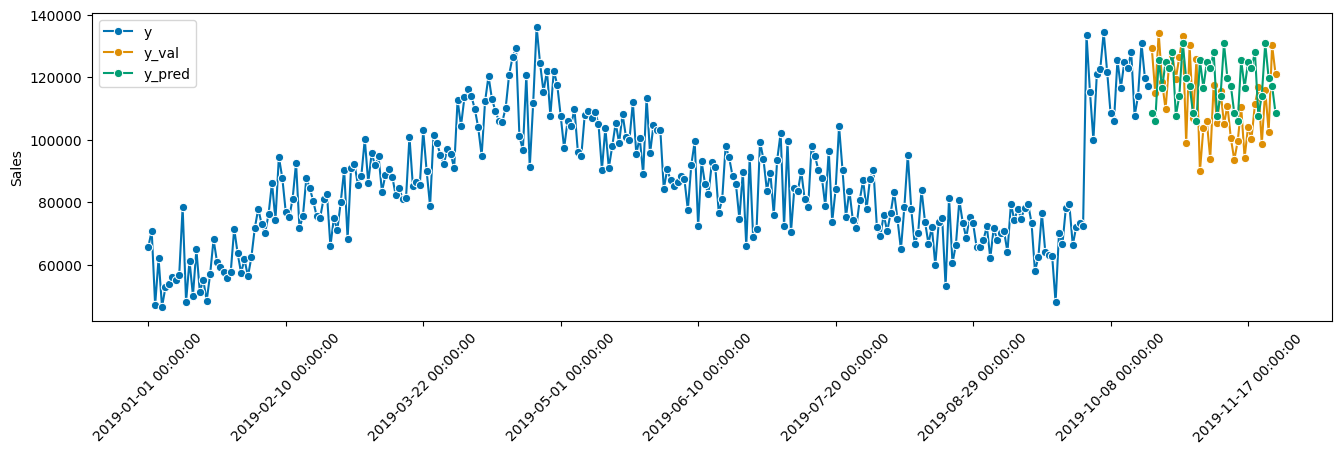

In [208]:
from sktime.utils.plotting import plot_series
plot_series(X_train,X_val, y_pred, labels=["y","y_val", "y_pred"])
plt.xticks(rotation=45)

In [209]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error
print("MAE:", mean_absolute_error(X_val, y_pred, squared=False))
print("MAPE:", mean_absolute_percentage_error(X_val, y_pred))

MAE: 13570.91837837838
MAPE: 0.1269916112997233


In [210]:
y_test_pred = forecaster.predict(fh=ForecastingHorizon(X_test.index, is_relative=False))  

(array([-4.,  0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 [Text(-4.0, 0, ''),
  Text(0.0, 0, '2019-11-26 00:00:00'),
  Text(4.0, 0, '2019-11-30 00:00:00'),
  Text(8.0, 0, '2019-12-04 00:00:00'),
  Text(12.0, 0, '2019-12-08 00:00:00'),
  Text(16.0, 0, '2019-12-12 00:00:00'),
  Text(20.0, 0, '2019-12-16 00:00:00'),
  Text(24.0, 0, '2019-12-20 00:00:00'),
  Text(28.0, 0, '2019-12-24 00:00:00'),
  Text(32.0, 0, '2019-12-28 00:00:00'),
  Text(36.0, 0, ''),
  Text(40.0, 0, '')])

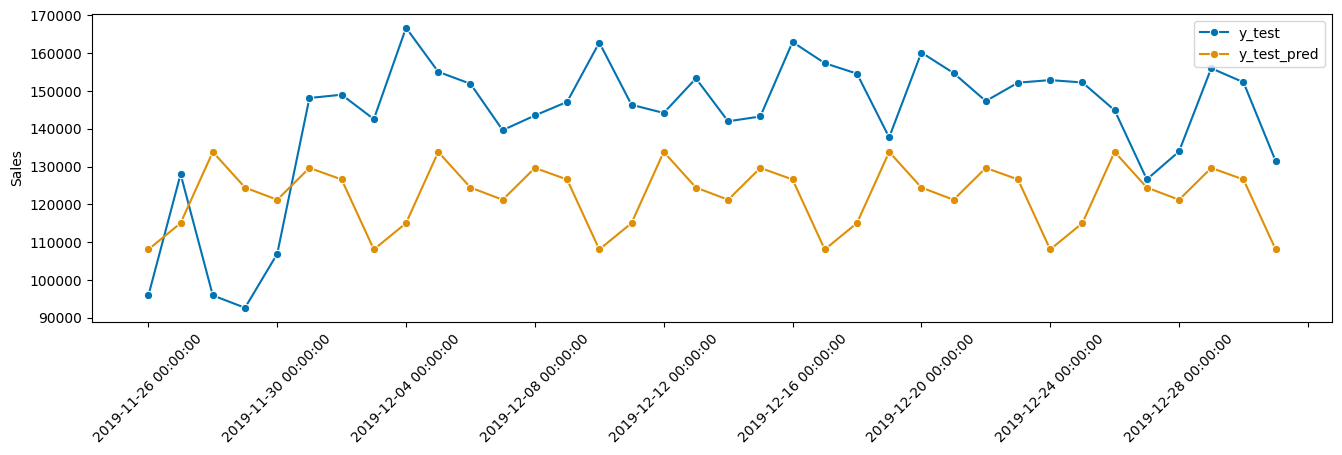

In [211]:
plot_series(X_test, y_test_pred, labels=["y_test", "y_test_pred"])
plt.xticks(rotation=45)

In [155]:
X_train.loc[:"2020-06-01"]

2019-01-01     65681.94
2019-01-02     70813.20
2019-01-03     47046.20
2019-01-04     62012.21
2019-01-05     46524.63
                ...    
2019-10-15    107623.75
2019-10-16    114107.87
2019-10-17    130827.84
2019-10-18    119705.72
2019-10-19    117261.52
Freq: D, Name: Sales, Length: 292, dtype: float64

C:\Users\MahamadiNikiema\AppData\Local\Temp\ipykernel_20708\2602837039.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


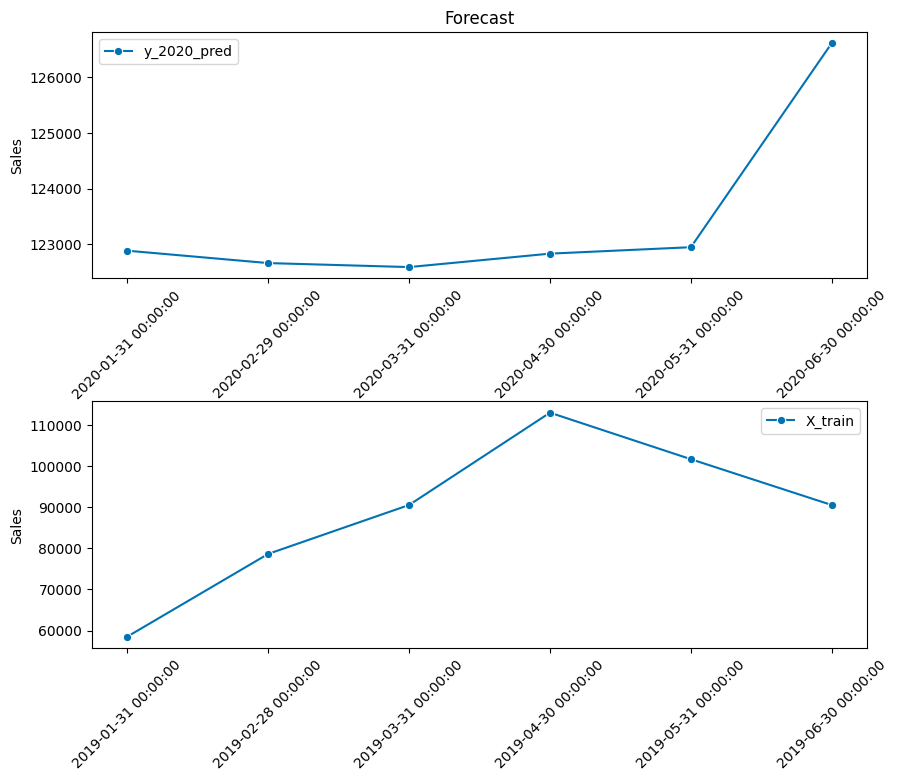

In [212]:
start_date = '2020-01-01'
end_date = '2020-06-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
fh_2020 = ForecastingHorizon(date_range, is_relative=False)
y_2020_pred = forecaster.predict(fh=fh_2020)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_series(y_2020_pred.resample('M').mean(), labels=["y_2020_pred"], ax=ax1)
ax1.set_title("Forecast")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
plot_series(X_train.loc[:"2019-06-01"].resample('M').mean(), labels=["X_train"], ax=ax2)
plt.xticks(rotation=45)
fig.subplots_adjust(hspace=0.5)